# Test QAOA - Cas très simplifié 


Considérons d'abord cette version simplifiée de notre problème d’optimisation, sert comme Benchmark: 

$\min_{g_i} \sum_{i \in G} c_i g_i$

Ici on traite juste les noeuds, pas de contraintes sur les lignes: 

les contraintes :


$0 \leq g_i \leq P_i \quad \forall i \in B$ $g_i$ est générée par un générateur, on suppose que c'est un entier positif

$\sum_{i \in B} g_i = \sum_{i \in B} D_i$

où les  $c_i$  sont des coefficients constants représentant les coûts associés, et $P_i$ sont des entiers naturels représentant les limites supérieures des variables $g_i$.


Pour décrire un entier $g_i \in \{0, \ldots, P_i\} $ avec des variables binaires, une approche initiale pourrait consister à introduire $P_i  $ variables binaires $x_0, \ldots, x_{P_i-1}$ et à remplacer $g_i$ par :

$g_i = \sum_{m = 0}^{P_i-1}  x_m$


In [ ]:
from qiskit.quantum_info import Pauli, SparsePauliOp
from itertools import combinations
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
import numpy as np
from scipy.optimize import minimize
from functools import reduce
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


In [ ]:
# exemples de valeurs 

q=2 #nombre de noeuds
P_i   = [4, 2]         
c_i   = [3,8]       # coût par noeud
D_i   = [3,1]        # demande par noeud

### Hamiltonien de coût

In [ ]:
# Génération des variables x(i,j) pour i correspond au ième noeud, j est le jème indicateur de g_i
x_vars = [(i, j) for i in range(q) for j in range(P_i[i])]
qubit_index = {f"x_{i}_{j}": idx for idx, (i,j) in enumerate(x_vars)}

def idx_x(i, j):
    return qubit_index[f"x_{i}_{j}"]



In [ ]:
terms = []
lam=1000 #pour la pénalité
D=np.sum(D_i)
N=sum(P_i)
nqubit=N
const = 0.0 #pour le terme constant de l'hamiltonien

# terme linéaire dans H_c
for (i, j) in x_vars:
    coeff_local =  -(c_i[i] + lam * (N - 2 * D))/2
    x_idx = idx_x(i, j)
    
    pauli = ['I'] * nqubit
    pauli[x_idx] = 'Z'
    terms.append((''.join(pauli), coeff_local))

    const += (c_i[i] + lam * (1 - 2 * D)) / 2
    
# le terme quadratique de H_c   
for a, (i, j) in enumerate(x_vars):
    for b, (k, l) in enumerate(x_vars):
        if b <= a:
            continue
        coeff_zz = lam/2
        
        pauli = ['I'] * nqubit
        pauli[idx_x(i, j)] = 'Z'
        pauli[idx_x(k, l)] = 'Z'
        terms.append((''.join(pauli), coeff_zz))
        

const += lam * D**2 + (lam * N * (N - 1)) / 4
# On rajoute la cte (indispensable pour trouver la valeur précise de l'expérance de H_c)
terms.append(('I' * nqubit, const))

In [5]:
H_c = SparsePauliOp.from_list(terms)

### Hamiltonien de mélange

In [ ]:
from qiskit.quantum_info import SparsePauliOp

H_M = SparsePauliOp.from_list([
    ('I'*i + 'X' + 'I'*(nqubit-i-1), 1.0)
    for i in range(nqubit)
])

print(H_M)

SparsePauliOp(['XIIIII', 'IXIIII', 'IIXIII', 'IIIXII', 'IIIIXI', 'IIIIIX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


### Les opérateurs d'évolution temporelle

In [7]:
from qiskit.circuit.library import PauliEvolutionGate
def U_C(gamma, H):
    gate = PauliEvolutionGate(H, time=gamma)
    return gate.definition  

def U_M(beta, H):
    gate = PauliEvolutionGate(H, time=beta)
    return gate.definition

### Construction du circuit QAOA

In [8]:
from qiskit import QuantumCircuit

def build_qaoa_circuit(n, p, gammas, betas, cost_h, mixer_h):
    qc = QuantumCircuit(n)  
    qc.h(range(n))          
    
    for layer in range(p):
        qc.append(U_C(float(gammas[layer]), cost_h), range(n))
        qc.append(U_M(float(betas[layer]), mixer_h), range(n))
    
    return qc 

### Exemple de circuit QAOA 

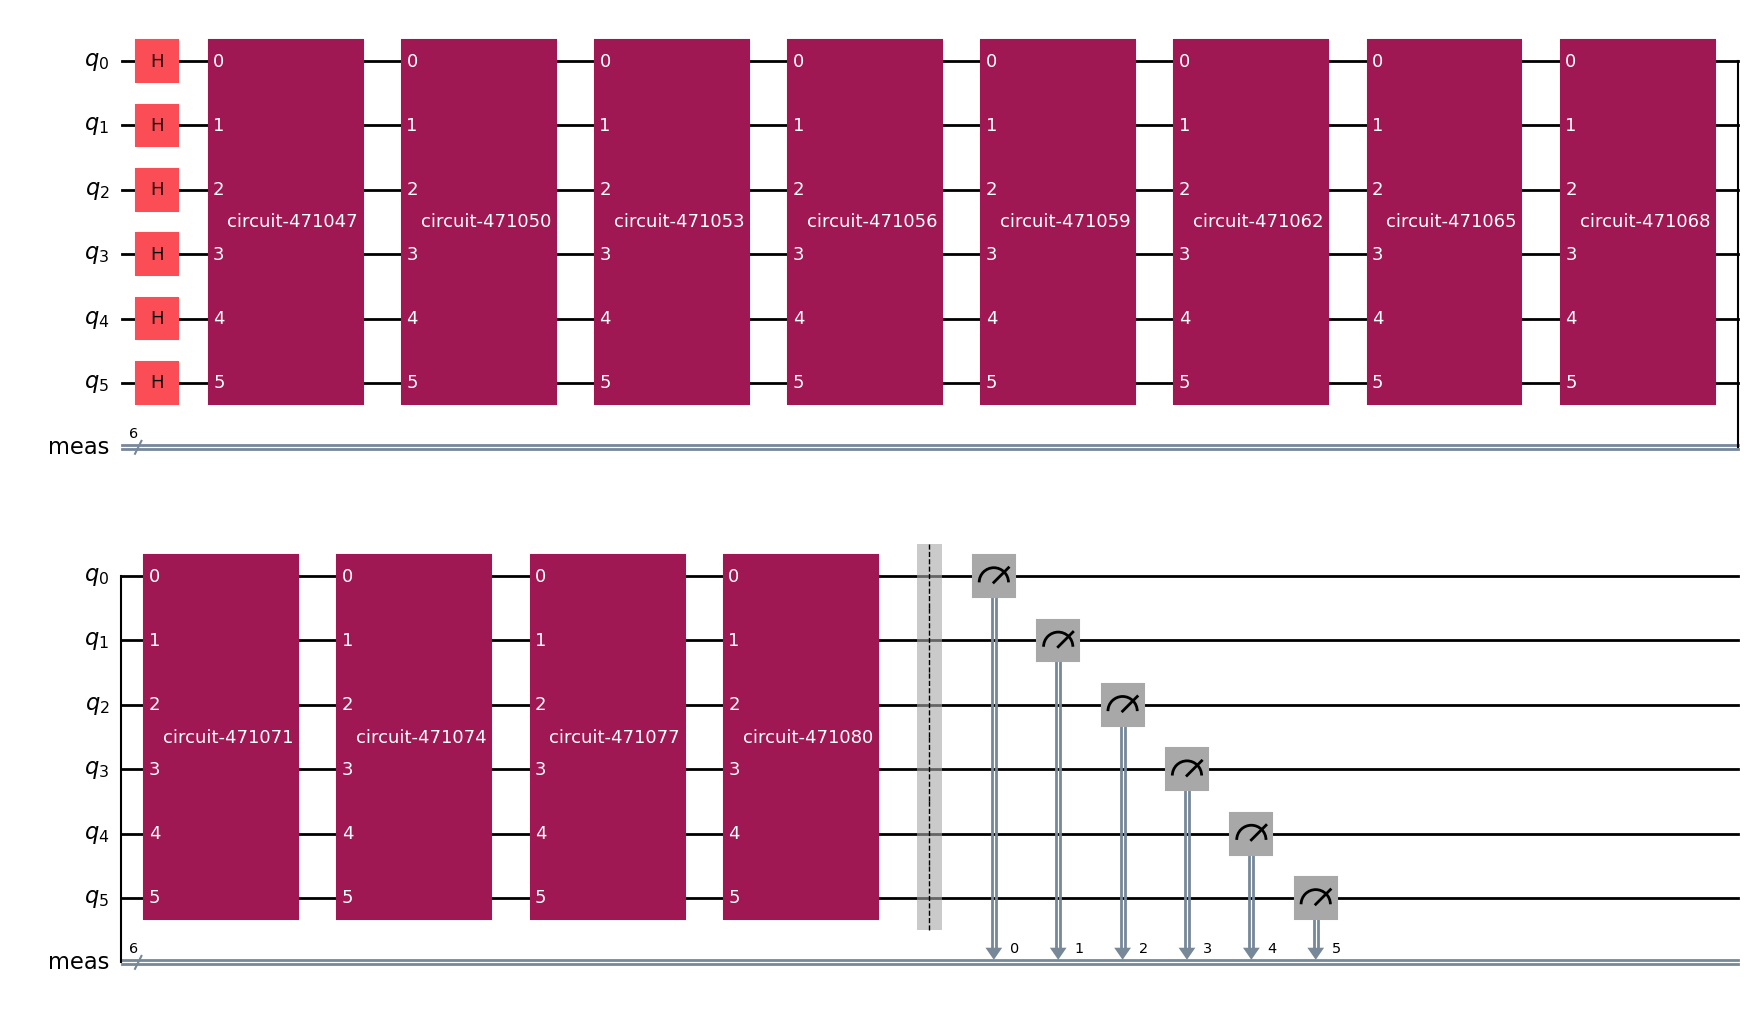

In [20]:
import pylatexenc
p=6
gammas=[np.pi/4, np.pi/2, np.pi/3, np.pi/5, np.pi/10, np.pi/6]
betas=[np.pi/8, np.pi/4, np.pi/6, np.pi/7, np.pi/9, np.pi/2]
params=[np.pi/4, np.pi/2, np.pi/3, np.pi/5 , np.pi/10, np.pi/6, np.pi/8, np.pi/4 , np.pi/6, np.pi/7, np.pi/9, np.pi/2]
cost_h=H_c
mixer_h=H_M
qc=build_qaoa_circuit(nqubit,p,gammas,betas,cost_h,mixer_h)
qc.measure_all()
qc.draw("mpl");

### Exemple d'histogramme de mesure QAOA

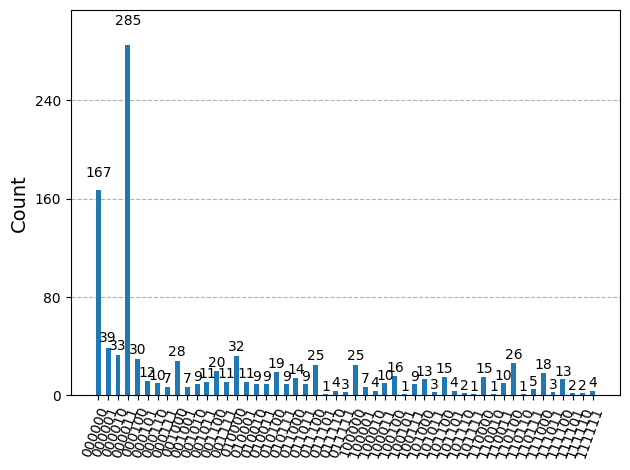

In [21]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator  
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


# Transpiler le circuit pour le backend
qc_transpiled = transpile(qc, AerSimulator())

job = AerSimulator().run(qc_transpiled, shots=1024) # Exécuter sur le simulateur
result = job.result()
counts = result.get_counts()

plot_histogram(counts);

### Fonction Objectif F_p

In [11]:
from qiskit import transpile
from qiskit_aer import Aer
import numpy as np
from scipy.optimize import minimize

backend = Aer.get_backend('aer_simulator')

def qaoa_expectation(params):
    gammas = params[:p]
    betas = params[p:]
    
    qc = build_qaoa_circuit(nqubit, p, gammas, betas, H_c, H_M)
    qc.save_statevector()
    
    qc_transpiled = transpile(qc, backend)
    result = backend.run(qc_transpiled).result()
    
    sv = result.data(0)['statevector']
    expval = sv.expectation_value(H_c)
    return np.real(expval)  

## Minimisation de F_p + Résultats optimaux

### Reslover: COBYLA

Paramètres optimaux : [1.00014696 0.44888668 0.89751232 1.34652826 1.79525532 3.49381358
 2.69283122 3.1416486  0.99993666 0.22445943 0.4578913  0.67324002
 0.89772346 1.12201637 1.34645017 1.5707307 ]
Espérance d'énergie minimale : 1000.7624212553578


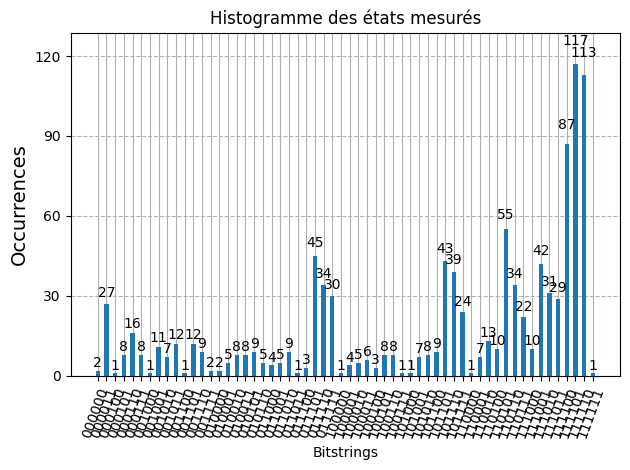

Top résultats QAOA:
111101 : 117 fois
111110 : 113 fois
111100 : 87 fois
110101 : 55 fois
011101 : 45 fois
Résultats de mesure : {'110000': 1, '111111': 1, '101000': 1, '000100': 1, '000000': 2, '011001': 5, '001110': 9, '100011': 6, '110010': 13, '110001': 7, '010010': 8, '000111': 8, '001011': 12, '000110': 16, '110100': 10, '001001': 11, '010011': 8, '100001': 4, '100111': 1, '011011': 1, '011111': 30, '011000': 4, '101001': 7, '011101': 45, '110111': 22, '100000': 1, '000011': 27, '001111': 2, '101100': 9, '101010': 8, '111010': 31, '100010': 5, '011110': 34, '101101': 43, '111000': 10, '110101': 55, '000101': 8, '001000': 1, '001100': 1, '111101': 117, '111011': 29, '101111': 24, '001101': 12, '010001': 5, '111110': 113, '010101': 9, '011100': 3, '111100': 87, '010000': 2, '100110': 8, '111001': 42, '001010': 7, '101110': 39, '011010': 9, '100100': 3, '110110': 34, '100101': 8, '010110': 5}
Temps d'exécution : 16.516873121261597 secondes


In [ ]:
%matplotlib inline
import time 
from collections import Counter

p=8 # la profondeur

#On initialise les valeurs de betas et gammas aléatoirement
gammas = np.linspace(0, np.pi, p) 
betas = np.linspace(0, np.pi/2, p)
params = np.concatenate([gammas, betas]) # point de départ --> initialisation



start = time.time() # on veut trouver le temps d'exécution

result = minimize(qaoa_expectation, params, method='COBYLA') #mesure

print("Paramètres optimaux :", result.x)
print("Espérance d'énergie minimale :", result.fun)

# Circuit avec les paramètres optimaux --> etat pi(beta, gamma)

gammas=result.x[:p]
betas=result.x[p:]

qc3 = build_qaoa_circuit(nqubit,p, gammas,betas,cost_h,mixer_h)
qc3.measure_all()
qc_transpiled3 = transpile(qc3, AerSimulator())

job = AerSimulator().run(qc_transpiled3, shots=1024)
result_new = job.result()
counts_new = result_new.get_counts()

#histogramme des probabilités
plot_histogram(counts_new)
plt.title("Histogramme des états mesurés")
plt.xlabel("Bitstrings")
plt.ylabel("Occurrences")
plt.grid(True)
plt.tight_layout()
plt.show()


# Affichage des 5 top résultats
print("Top résultats QAOA:")
for bitstring, freq in Counter(counts_new).most_common(5):
    print(f"{bitstring} : {freq} fois")
    

print("Résultats de mesure :", counts_new)

end = time.time()
print("Temps d'exécution :", end - start, "secondes") #renvoie le temps d'exécution




### Resolver: Nelder-Mead

Paramètres optimaux : [ 3.91348153e-04  4.50839050e-01  9.08838509e-01  1.35975301e+00
  1.73996915e+00  2.24801394e+00  2.69069198e+00  3.15675232e+00
 -1.55691207e-04  1.82485728e-01  4.85211993e-01  6.75297678e-01
  8.47292748e-01  1.16604112e+00  1.36940431e+00  1.68850251e+00]
Espérance d'énergie minimale : 604.5802273036645


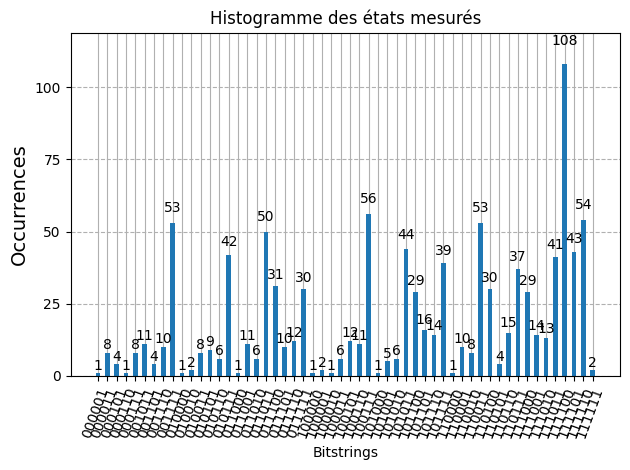

Top résultats QAOA:
111100 : 108 fois
100111 : 56 fois
111110 : 54 fois
001111 : 53 fois
110011 : 53 fois
Résultats de mesure : {'101000': 1, '100001': 2, '011000': 1, '110010': 8, '010101': 9, '010010': 2, '011010': 6, '001011': 11, '100010': 1, '011110': 12, '101101': 16, '100101': 12, '000110': 1, '000001': 1, '011001': 11, '001110': 10, '100011': 6, '111111': 2, '101110': 14, '111110': 54, '101010': 6, '001111': 53, '101100': 29, '011100': 31, '111100': 108, '010000': 1, '100110': 11, '111101': 43, '111001': 14, '101111': 39, '010111': 42, '111011': 41, '110011': 53, '010011': 8, '111010': 13, '110100': 30, '000101': 4, '011011': 50, '100111': 56, '011111': 30, '110101': 4, '111000': 29, '000111': 8, '100000': 1, '000011': 8, '110111': 37, '010110': 6, '110000': 1, '110001': 10, '110110': 15, '011101': 10, '101001': 5, '101011': 44, '001101': 4}
Temps d'exécution : 364.17546939849854 secondes


In [ ]:
%matplotlib inline

p=8
gammas = np.linspace(0, np.pi, p)
betas = np.linspace(0, np.pi/2, p)
params = np.concatenate([gammas, betas]) # point de départ --> initialisation

import time


start = time.time()

#mesure
result = minimize(qaoa_expectation, params, method='Nelder-Mead')


print("Paramètres optimaux :", result.x)
print("Espérance d'énergie minimale :", result.fun)

# Circuit avec les paramètres optimaux

gammas=result.x[:p]
betas=result.x[p:]

qc3 = build_qaoa_circuit(nqubit,p, gammas,betas,cost_h,mixer_h)
qc3.measure_all()
qc_transpiled3 = transpile(qc3, AerSimulator())

job = AerSimulator().run(qc_transpiled3, shots=1024)
result_new = job.result()
counts_new = result_new.get_counts()


plot_histogram(counts_new)
plt.title("Histogramme des états mesurés")
plt.xlabel("Bitstrings")
plt.ylabel("Occurrences")
plt.grid(True)
plt.tight_layout()
plt.show()


from collections import Counter

# Affichage des top résultats
print("Top résultats QAOA:")
for bitstring, freq in Counter(counts_new).most_common(5):
    print(f"{bitstring} : {freq} fois")

print("Résultats de mesure :", counts_new)

end = time.time()
print("Temps d'exécution :", end - start, "secondes")




### Resolver: Powell

Paramètres optimaux : [ 1.06028226  0.36992877  0.89767353  1.34631138  1.7950518   2.21883356
  2.69267583  5.14152151 -0.09573245  0.30800903  0.44425555  0.60333861
  0.83039588  1.01330517  1.15174215  1.74197326]
Espérance d'énergie minimale : 147.8410958360014


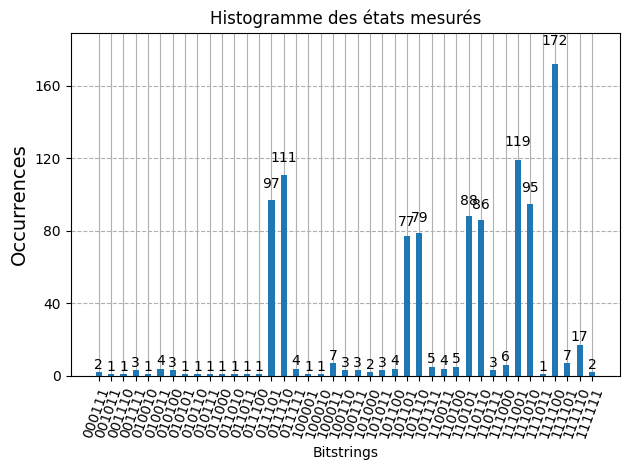

Top résultats QAOA:
111100 : 172 fois
111001 : 119 fois
011110 : 111 fois
011101 : 97 fois
111010 : 95 fois
Résultats de mesure : {'010110': 1, '010101': 1, '010010': 1, '001011': 1, '110100': 5, '001110': 1, '011010': 1, '110111': 3, '011101': 97, '110011': 4, '101111': 5, '111110': 17, '111011': 1, '010100': 3, '010111': 1, '011100': 1, '111100': 172, '100110': 3, '100010': 1, '011110': 111, '101101': 77, '111010': 95, '101011': 3, '110110': 86, '101110': 79, '111001': 119, '111111': 2, '001111': 3, '101100': 4, '000111': 2, '110101': 88, '111000': 6, '010011': 4, '100001': 1, '011000': 1, '011011': 1, '100111': 3, '011111': 4, '100011': 7, '111101': 7, '101000': 2}
Temps d'exécution : 650.7290740013123 secondes


In [ ]:
%matplotlib inline

p=8
gammas = np.linspace(0, np.pi, p)
betas = np.linspace(0, np.pi/2, p)
params = np.concatenate([gammas, betas]) # point de départ --> initialisation

import time


start = time.time()

#mesure
result = minimize(qaoa_expectation, params, method='Powell')


print("Paramètres optimaux :", result.x)
print("Espérance d'énergie minimale :", result.fun)

# Circuit avec les paramètres optimaux

gammas=result.x[:p]
betas=result.x[p:]

qc3 = build_qaoa_circuit(nqubit,p, gammas,betas,cost_h,mixer_h)
qc3.measure_all()
qc_transpiled3 = transpile(qc3, AerSimulator())

job = AerSimulator().run(qc_transpiled3, shots=1024)
result_new = job.result()
counts_new = result_new.get_counts()


plot_histogram(counts_new)
plt.title("Histogramme des états mesurés")
plt.xlabel("Bitstrings")
plt.ylabel("Occurrences")
plt.grid(True)
plt.tight_layout()
plt.show()


from collections import Counter

# Affichage des top résultats
print("Top résultats QAOA:")
for bitstring, freq in Counter(counts_new).most_common(5):
    print(f"{bitstring} : {freq} fois")


print("Résultats de mesure :", counts_new)

end = time.time()
print("Temps d'exécution :", end - start, "secondes")




## Test pour plusieurs valeurs de p la profondeur

In [ ]:
from collections import defaultdict

def decode_from_named_x_vars(x_values): # une fonction auxilaire que je définis
    """
    Décode un dictionnaire de variables binaires x_{i,j} en une liste des valeurs g_i.
    
    Args:
        x_values (dict): Par ex. {'x_0_0': 0, 'x_0_1': 1, 'x_1_0': 0, ...}
    
    Returns:
        list: Liste [g_0, g_1, ...] où g_i est l'index activé (j) ou 0 par défaut.
    """
    grouped_vars = defaultdict(dict)
    
    for var, val in x_values.items():
        _, i, j = var.split("_")
        grouped_vars[int(i)][int(j)] = val

    decoded = []
    for i in sorted(grouped_vars.keys()):
        val_dict = grouped_vars[i]
        active = [j for j, v in val_dict.items() if v == 1]
        if len(active) > 1:
            raise ValueError(f"Plusieurs bits actifs pour g_{i} : {active}")
        decoded.append(active[0] if active else 0)

    return decoded


In [ ]:
import time

p_values = list(range(1, 10))  # p = 1 à 50 inclus
execution_times = []
costs = []  # Coût associé au meilleur bitstring pour chaque p
solutions = []  # Pour stocker les valeurs g_i décodées

for p in p_values:
    start = time.time()
    gammas = np.linspace(0, np.pi, p)
    betas = np.linspace(0, np.pi/2, p)
    params = np.concatenate([gammas, betas]) # point de départ --> initialisation


    #mesure
    result = minimize(qaoa_expectation, params, method='COBYLA')

    # print("Pour p=", p, " on a les paramètres optimaux :", result.x)
    #print("Espérance d'énergie minimale :", -result.fun)

    # Circuit avec les paramètres optimaux

    gammas=result.x[:p]
    betas=result.x[p:]

    qc3 = build_qaoa_circuit(nqubit,p, gammas,betas,cost_h,mixer_h)
    qc3.measure_all()
    qc_transpiled3 = transpile(qc3, AerSimulator())

    job = AerSimulator().run(qc_transpiled3, shots=1024)
    result_new = job.result()
    counts_new = result_new.get_counts()
    end = time.time()
    execution_times.append(end - start)
    

# Convertir le bitstring en x_values
    index_to_var = {v: k for k, v in qubit_index.items()}
    bit_values = {index_to_var[i]: int(best_bitstring[i]) for i in range(len(best_bitstring))}
    x_values = {k: v for k, v in bit_values.items() if k.startswith("x_")}

# Décodage
    decoded = decode_from_named_x_vars(x_values)
    cost = sum(c_i * g_i for c_i, g_i in zip([10, 8], decoded))
    costs.append(cost)
    solutions.append(decoded)
    
    best_bitstring = max(counts_new, key=counts_new.get)


    print("Pour p=",p, ", Bitstring le plus probable :", best_bitstring, "avec Nombre d'occurrences :", counts_new[best_bitstring])



Pour p= 1 , Bitstring le plus probable : 001011 avec Nombre d'occurrences : 81
Pour p= 2 , Bitstring le plus probable : 111100 avec Nombre d'occurrences : 585
Pour p= 3 , Bitstring le plus probable : 111100 avec Nombre d'occurrences : 578
Pour p= 4 , Bitstring le plus probable : 111100 avec Nombre d'occurrences : 300
Pour p= 5 , Bitstring le plus probable : 111100 avec Nombre d'occurrences : 584
Pour p= 6 , Bitstring le plus probable : 111100 avec Nombre d'occurrences : 454
Pour p= 7 , Bitstring le plus probable : 111111 avec Nombre d'occurrences : 92
Pour p= 8 , Bitstring le plus probable : 111110 avec Nombre d'occurrences : 120
Pour p= 9 , Bitstring le plus probable : 111100 avec Nombre d'occurrences : 453


### Temps d'exécution en fonction de la profondeur

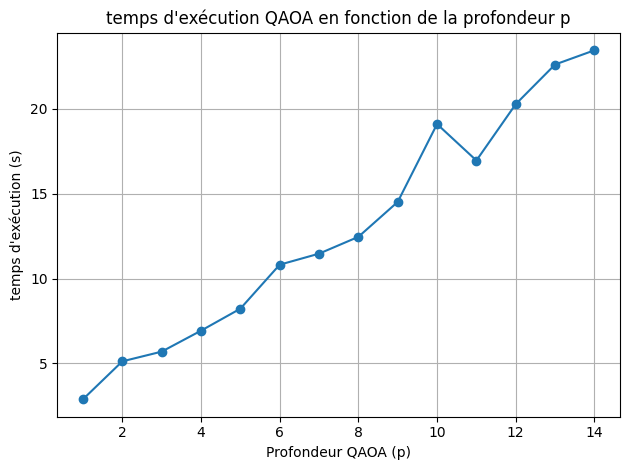

In [ ]:
import matplotlib.pyplot as plt

plt.plot(p_values, execution_times, marker='o')
plt.xlabel("Profondeur QAOA (p)")
plt.ylabel("temps d'exécution (s)")
plt.title ("temps d'exécution QAOA en fonction de la profondeur p")
plt.grid(True)
plt.tight_layout()
plt.show()